- to generate new baseline based on cosine similarity

In [2]:
import itertools

import matplotlib as mpl
mpl.use('agg')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
from IPython.display import display
from matplotlib.font_manager import fontManager, FontProperties
from explain.plot import latexify
import sklearn
import sklearn.preprocessing as preprocessing
from sklearn.metrics.pairwise import cosine_similarity
import pylab as pl
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from scipy.stats import rankdata, zscore
import matplotlib.gridspec as gridspec

In [42]:
#for claritytrec
path = '/home/alawlor/work/explanationframework/data/hdf/explanations_baselines.h5'

with pd.HDFStore(path, format='f', mode='r') as store:
    print store
    df_basic = store['df_basic']
    df_main = store['df_scores_original']
    df_amenities = store['df_amenities']
    df_hotel_profiles = store['df_hotel_profiles']
    df_hotel_features = store['df_hotel_features']
    df_scores_original = store['df_scores_original']

<class 'pandas.io.pytables.HDFStore'>
File path: /home/alawlor/work/explanationframework/data/hdf/explanations_baselines.h5
/df_amenities                     frame        (shape->[1,1])      
/df_basic                         frame        (shape->[301653,18])
/df_hotel_features                frame        (shape->[1,6])      
/df_hotel_profile_dict            frame        (shape->[1,2298])   
/df_hotel_profiles                frame        (shape->[1,2])      
/df_review_ratings                frame        (shape->[224760,4]) 
/df_scores_original               frame        (shape->[301653,38])
/df_sessions_rh                   frame        (shape->[1,4])      
/df_user_features                 frame        (shape->[1,6])      
/df_user_profile_dict             frame        (shape->[1,10000])  
/df_user_profiles                 frame        (shape->[1,9])      


In [46]:
df_hotel_profiles[df_hotel_profiles['hotel_id']=='Phoenix_Park_Hotel']

,hotel_id,name,star,percentage,average_rating,traveller_rating,review_for,amenities,city,mentions,opinion_ratio,polarity_ratio,senti_avg,pros_pol,cons_pol,price_range_value,related_hotels,related_hotels_sims
1512,Phoenix_Park_Hotel,Phoenix Park Hotel,3.5,55.0,3,Poor:9;Very good:28;Average:10;Terrible:21;Exc...,Family reviews:13;Couples reviews:19;Solo trav...,,Dublin,"[0.0, 0.828488372093, 0.0, 0.0188953488372, 0....","[0.0, 0.621052631579, 0.0, 0.769230769231, 0.0...","[0.0, 0.652542372881, 0.0, 0.7, 0.0, 0.0, 0.0,...","[0.0, 0.0842195893775, 0.0, 0.173931623932, 0....","[False, True, False, True, False, False, False...","[True, False, True, False, True, True, True, T...",1,"[Dergvale_Hotel, Ballsbridge_Hotel, Lynam_s_Ho...","[0.958447103744, 0.956796572961, 0.95451719290..."


In [51]:
2370 - len(df_hotel_features.hotel_id.unique())

72

In [52]:
df_hotel_features.head()

,amenity,hotel_id,mentions,opinion_ratio,polarity_ratio,senti_avg
0,airport transportation,Lynam_s_Hotel,0.008299,0.900000,0.777778,0.279405
1,bar/lounge,Lynam_s_Hotel,0.024896,0.600000,0.611111,0.096305
2,business center,Lynam_s_Hotel,0.007469,0.555556,0.800000,0.134259
3,free breakfast,Lynam_s_Hotel,0.039834,0.687500,0.818182,0.183242
4,free high-speed internet,Lynam_s_Hotel,0.003320,0.750000,1.000000,0.375000


In [53]:
df_amenities[:3]

,amenity
0,suites
1,room service
2,wheelchair access


In [54]:
df_amenities.query('amenity == "wheelchair access"').index[0]

2

In [55]:
df_hotel_features.head()

,amenity,hotel_id,mentions,opinion_ratio,polarity_ratio,senti_avg
0,airport transportation,Lynam_s_Hotel,0.008299,0.900000,0.777778,0.279405
1,bar/lounge,Lynam_s_Hotel,0.024896,0.600000,0.611111,0.096305
2,business center,Lynam_s_Hotel,0.007469,0.555556,0.800000,0.134259
3,free breakfast,Lynam_s_Hotel,0.039834,0.687500,0.818182,0.183242
4,free high-speed internet,Lynam_s_Hotel,0.003320,0.750000,1.000000,0.375000


In [56]:
# df_hotel_features.groupby('hotel_id').amenity.size().hist()

In [57]:
# def gen():
#     for hotel_id, df in df_hotel_features.groupby('hotel_id'):
#         yield df.mentions.tolist()
# pd.DataFrame(gen()).head(50)
hotel_amenity_matrix = pd.pivot_table(data=df_hotel_features, values='mentions', 
                                      columns='hotel_id', index='amenity').T.fillna(0)

In [58]:
hotel_amenity_matrix.head()

amenity,airport transportation,bar/lounge,beach,beverage selection,business center,fitness center,free breakfast,free high-speed internet,free parking,kids activities,kitchenette,pets allowed,restaurant,room service,shuttle bus service,spa,suites,swimming pool,wheelchair access
hotel_id,,,,,,,,,,,,,,,,,,,
10_Lee_s_Place,0.000000,0.000000,0,0,0.055556,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0,0.000000,0.750000,0.111111,0.000000,0.000000,0,0
130_Queen_s_Gate_Apartments,0.009211,0.006579,0,0,0.017105,0.001316,0.014474,0.001316,0.007895,0.001316,0.009211,0,0.018421,0.831579,0.081579,0.000000,0.000000,0,0
196_Bishopsgate,0.000994,0.010934,0,0,0.021869,0.000000,0.041750,0.006958,0.001988,0.000994,0.006958,0,0.025845,0.804175,0.073559,0.000000,0.003976,0,0
1_Lexham_Gardens,0.002536,0.010989,0,0,0.005072,0.000000,0.051564,0.000845,0.004227,0.000000,0.000000,0,0.004227,0.875740,0.040575,0.000845,0.003381,0,0
21_Whitfield,0.014085,0.028169,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028169,0,0.014085,0.676056,0.225352,0.000000,0.014085,0,0


In [59]:
len(hotel_amenity_matrix)

2298

In [60]:
def get_hotel_mentions(hotel_id):
    return (pd.DataFrame(hotel_amenity_matrix.ix[hotel_id])
             .reset_index()
             .rename(columns={hotel_id: 'mentions'})
             .merge(df_amenities.reset_index(), on='amenity')
             .sort_values('index').mentions.tolist())

In [61]:
def gen():
    for hotel_id in hotel_amenity_matrix.index.tolist():
        yield dict(hotel_id=hotel_id,
                    target_hotel_mentions=get_hotel_mentions(hotel_id), 
                   related_hotels=df_hotel_profiles[df_hotel_profiles['hotel_id']==hotel_id].related_hotels.values[0],
                   city=df_hotel_profiles[df_hotel_profiles['hotel_id']==hotel_id].city.values[0],
                   average_rating=df_hotel_profiles[df_hotel_profiles['hotel_id']==hotel_id].average_rating.values[0],
                   price_range_value=df_hotel_profiles[df_hotel_profiles['hotel_id']==hotel_id].price_range_value.values[0],
                   star=df_hotel_profiles[df_hotel_profiles['hotel_id']==hotel_id].star.values[0])
        
df_basic4 = pd.DataFrame(gen())

In [62]:
df_basic4[:3]

,average_rating,city,hotel_id,price_range_value,related_hotels,star,target_hotel_mentions
0,4.5,London,10_Lee_s_Place,3,"[The_House_Hotel, Travelodge_London_Whetstone,...",3.5,"[0.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05..."
1,4.5,London,130_Queen_s_Gate_Apartments,4,"[Think_Earl_s_Court, Citadines_Prestige_Holbor...",5.0,"[0.0, 0.831578947368, 0.0, 0.0184210526316, 0...."
2,4.0,London,196_Bishopsgate,2,"[Sydney_House, Abbey_Court_Hyde_Park, Prince_s...",4.0,"[0.00397614314115, 0.804174950298, 0.0, 0.0258..."


In [63]:
print len(df_basic4)

2298


In [64]:
df_basic4[:2]

,average_rating,city,hotel_id,price_range_value,related_hotels,star,target_hotel_mentions
0,4.5,London,10_Lee_s_Place,3,"[The_House_Hotel, Travelodge_London_Whetstone,...",3.5,"[0.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05..."
1,4.5,London,130_Queen_s_Gate_Apartments,4,"[Think_Earl_s_Court, Citadines_Prestige_Holbor...",5.0,"[0.0, 0.831578947368, 0.0, 0.0184210526316, 0...."


In [1516]:

#df_basic3 = df_basic.groupby('hotel_id').agg({'target_hotel_mention_zscore': lambda x: str(x.iloc[0])}).reset_index()
#df_basic3[:4]


In [66]:
df_hotel_profiles[:3]

,hotel_id,name,star,percentage,average_rating,traveller_rating,review_for,amenities,city,mentions,opinion_ratio,polarity_ratio,senti_avg,pros_pol,cons_pol,price_range_value,related_hotels,related_hotels_sims
0,10_Lee_s_Place,10 Lee's Place,3.5,NaN,4.5,Very good:1;Excellent:1,Family reviews:1;Business reviews:1,,London,"[0.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05...","[0.0, 0.666666666667, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.777777777778, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.164285714286, 0.0, 0.0, 0.0, 0.0, 0.0,...","[False, True, False, False, False, False, Fals...","[True, False, True, True, True, True, True, Tr...",3,"[The_House_Hotel, Travelodge_London_Whetstone,...","[0.926395145835, 0.842649988598, 0.82308289240..."
1,130_Queen_s_Gate_Apartments,130 Queen's Gate Apartments,5.0,94.0,4.5,Very good:14;Average:3;Terrible:2;Excellent:66,Family reviews:38;Couples reviews:18;Solo trav...,"Business Center,Fitness Center,Free High-Speed...",London,"[0.0, 0.831578947368, 0.0, 0.0184210526316, 0....","[0.0, 0.632911392405, 0.0, 0.714285714286, 0.0...","[0.0, 0.8275, 0.0, 0.9, 0.0, 0.833333333333, 0...","[0.0, 0.211828690385, 0.0, 0.32380952381, 0.0,...","[False, True, False, True, False, True, False,...","[True, False, True, False, True, False, True, ...",4,"[Think_Earl_s_Court, Citadines_Prestige_Holbor...","[0.899153587012, 0.88333329246, 0.872035138987..."
2,196_Bishopsgate,196 Bishopsgate,4.0,83.0,4.0,Poor:13;Very good:74;Average:22;Terrible:3;Exc...,Family reviews:51;Couples reviews:44;Solo trav...,"Kitchenette,Shuttle Bus service",London,"[0.00397614314115, 0.804174950298, 0.0, 0.0258...","[0.25, 0.645241038319, 0.0, 0.5, 0.0, 0.428571...","[1.0, 0.735632183908, 0.0, 0.769230769231, 0.0...","[0.1, 0.159897763615, 0.0, 0.161843711844, 0.0...","[True, True, False, True, False, True, False, ...","[False, False, True, False, True, False, True,...",2,"[Sydney_House, Abbey_Court_Hyde_Park, Prince_s...","[0.923207182244, 0.909373534625, 0.90515350387..."


In [67]:
hotel_city_dict = dict(zip(df_hotel_profiles.hotel_id, df_hotel_profiles.city))
hotel_avgRating_dict = dict(zip(df_hotel_profiles.hotel_id, df_hotel_profiles.average_rating))
hotel_price_dict = dict(zip(df_hotel_profiles.hotel_id, df_hotel_profiles.price_range_value))
hotel_star_dict = dict(zip(df_hotel_profiles.hotel_id, df_hotel_profiles.star))
hotel_trip_related_dict = dict(zip(df_hotel_profiles.hotel_id, df_hotel_profiles.related_hotels))


In [68]:
print len(hotel_city_dict)

2298


In [69]:
basic3 = []
hidSet = set()
for xind in range(len(df_basic)):
    if df_basic.iloc[xind].hotel_id in hidSet:
        continue
    else:
        hidSet.add(df_basic.iloc[xind].hotel_id)
        basic3.append({'hotel_id':df_basic.iloc[xind].hotel_id,'target_hotel_mentions':df_basic.iloc[xind].target_hotel_mentions,'target_hotel_mention_zscore':df_basic.iloc[xind].target_hotel_mention_zscore,'city':hotel_city_dict[df_basic.iloc[xind].hotel_id],'star':hotel_star_dict[df_basic.iloc[xind].hotel_id],'related_hotels':hotel_trip_related_dict[df_basic.iloc[xind].hotel_id],'price_range_value':hotel_price_dict[df_basic.iloc[xind].hotel_id],'average_rating':hotel_avgRating_dict[df_basic.iloc[xind].hotel_id]})
        
    

In [70]:
df_basic3 = pd.DataFrame(basic3)

In [71]:
print len(df_basic3)

2191


In [72]:
df_basic3[:3]

,average_rating,city,hotel_id,price_range_value,related_hotels,star,target_hotel_mention_zscore,target_hotel_mentions
0,3.0,Dublin,Phoenix_Park_Hotel,1,"[Dergvale_Hotel, Ballsbridge_Hotel, Lynam_s_Ho...",3.5,"[-0.28673133785, 4.2267866693, -0.28673133785,...","[0.0, 0.828488372093, 0.0, 0.0188953488372, 0...."
1,2.5,Dublin,Jackson_Court_Hotel,1,"[Browns_Hotel_and_Apartments, Russell_Court_Ho...",2.0,"[-0.265881712205, 4.22357327638, -0.2792697489...","[0.00252312867956, 0.848612279226, 0.0, 0.0075..."
2,2.5,Dublin,Barry_s_Hotel,1,"[Le_Cirk_Hotel, My_Place_Dublin_Hotel, Park_In...",2.0,"[-0.279514382893, 4.22206296413, -0.2863143486...","[0.00125, 0.82875, 0.0, 0.01, 0.0, 0.0, 0.0025..."


In [73]:
mentions = np.array([z for z in df_basic3.target_hotel_mentions])

In [74]:
print mentions[0,:]

[ 0.          0.82848837  0.          0.01889535  0.          0.          0.
  0.          0.01162791  0.04069767  0.01889535  0.00581395  0.06104651
  0.          0.01162791  0.          0.          0.          0.00290698]


In [75]:
unique_hotel_explns = df_scores_original[df_scores_original.is_seed == True].groupby('hotel_id').apply(lambda x: x.head(1))
#mentions = np.array([z for z in unique_hotel_explns.target_hotel_mentions])


In [76]:
unique_hotel_explns[unique_hotel_explns['hotel_id']=='Hazelbrook_House']

,,better_count,better_pro_scores,explanation_id,hotel_id,is_seed,seed_hotel_id,senti_better_alternatives,session_id,target_hotel_mention_rankscore,target_hotel_mention_zscore,...,pros_comp,strength,strength_comp,worse_avg,worse_avg_comp,rank_star,rank_average_rating,rank_strength,rank_strength_comp,rank_related_hotels_sims
hotel_id,,,,,,,,,,,,,,,,,,,,,,
Hazelbrook_House,21011,"[0, 3, 0, 10, 0, 0, 0, 0, 2, 8, 10, 5, 6, 0, 7...","[0.0, 0.3, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.2, ...",98DD28A93C501681E61B3200363C31E2#Hazelbrook_Ho...,Hazelbrook_House,True,Hazelbrook_House,"[[False, False, False, True, False, False, Fal...",98DD28A93C501681E61B3200363C31E2#Hazelbrook_House,"[0.0281869611821, 0.281869611821, 0.0148352427...","[-0.281141386765, 4.21951349414, -0.2868240318...",...,"[False, False, False, False, False, False, Fal...",0.4,0.4,0.85,0.85,0,0,0,0,0


In [77]:
df_all_original_version = pd.read_csv('/home/alawlor/work/explanationframework/data/ta_hotels.csv');
df_all_original_version[:3]

,hotel_id,seq,name,room_num,star,street,extend_address,locality,region,postal_code,...,traveller_rating,review_for,rating_sum,amenities,related_hotels,city,date,num,num_at_least_ten_reviews,all_amenities
0,10_Aarden_Hotel,723,10 Aarden Hotel,35,NaN,10-12 St. Georges Drive,null,London,null,SW1V 4BJ,...,Average:1;Excellent:1,Family reviews:1,NaN,NaN,"Wimbledon_Hotel,Antoinette_Hotel_Wimbledon,Pre...",London,06/09/2013,1073,920,"Room Service,Kids Activities,Free High-Speed I..."
1,10_Lee_s_Place,618,10 Lee's Place,12,NaN,"Shepherds Place, Grosvenor Square",null,London,null,W1K 6LL,...,Very good:1;Excellent:1,Family reviews:1;Business reviews:1,NaN,NaN,"Go_Native_Mayfair_Apartments,No_5_Maddox_Stree...",London,06/09/2013,1073,920,"Room Service,Kids Activities,Free High-Speed I..."
2,130_Queen_s_Gate_Apartments,70,130 Queen's Gate Apartments,50,5,130 Queen's Gate,South Kensington,London,null,SW7 5LE,...,Very good:14;Average:3;Terrible:2;Excellent:66,Family reviews:38;Couples reviews:18;Solo trav...,NaN,"Business Center,Fitness Center,Free High-Speed...","Collingham_Serviced_Apartments,The_Harrington,...",London,06/09/2013,1073,920,"Room Service,Kids Activities,Free High-Speed I..."


In [78]:
print len(df_all_original_version)

2370


### Base function

In [79]:
def generateAverageOfRelated(df_h_profie, df_related, key):
    result = {}
    count = 0;
    for xindex,xr in df_related.iterrows():
        idx = df_h_profie['hotel_id'].isin(xr.related_hotels)
        df_n = df_h_profie[idx]
        count = count+len(df_n)
        #print len(df_n)
        result[xr.hotel_id] = df_n[key].mean()
    
        #print xr.hotel_id
        #print result[xr.hotel_id]
    print count/len(result)
    return result
           

In [80]:
trip_average_rating = generateAverageOfRelated(df_all_original_version,df_hotel_profiles,'average_rating')

10


In [81]:
#{hotel_id,index}
def get_hotelId_index_dic(hp_df):
    #return pd.Series(hp_df.hotel_id.values,index=range(0,len(hp_df))).to_dict()
    result = {}
    for ind in range(0,len(hp_df)):
        result[hp_df.iloc[ind].hotel_id]=ind
    return result


In [82]:
#get trip based related hotel matrix, each line is a set of hotel_ids of its related hotels
def get_hotel_related_matrix(hp_df):
    rx = np.array([z for z in hp_df.related_hotels])
    return rx

In [83]:
print get_hotel_related_matrix(df_basic3)

[['Dergvale_Hotel' 'Ballsbridge_Hotel' 'Lynam_s_Hotel' ...,
  'Caulfield_s_Hotel' 'Arlington_Hotel_Temple_Bar' 'Ripley_Court_Hotel']
 ['Browns_Hotel_and_Apartments' 'Russell_Court_Hotel' 'Leeson_Inn_Downtown'
  ..., 'Dergvale_Hotel' 'Sunnybank_Hotel' 'The_Belvedere_Hotel']
 ['Le_Cirk_Hotel' 'My_Place_Dublin_Hotel' 'Park_Inn_Dublin' ...,
  'The_Belvedere_Hotel' 'Browns_Hotel_and_Apartments' 'Maple_Hotel']
 ..., 
 ['Yo_Hotel' 'Golden_Ocean_Hotel' 'Madera_Residences' ...,
  'Bridal_Tea_House_Hotel_Hung_Hom_Wuhu_Street'
  'Bridal_Tea_House_Hotel_Western_District' 'Mini_Hotel_Central_Hong_Kong']
 ['Milshire_Hotel' 'Chicago_Athletic_Association' 'Rio_Motel' ...,
  'New_Jackson_Hotel' 'Hotel_Felix' 'Sheffield_House']
 ['Ohio_House_Motel' 'Sheffield_House' 'Congress_Plaza_Hotel' ...,
  'Hard_Rock_Hotel_Chicago' 'The_Silversmith_Hotel_Suites'
  'The_Blackstone_A_Renaissance_Hotel']]


In [84]:
def get_sim(hp_df,h_sim_matrix,hotel_idx, k=10):
    hotels = h_sim_matrix[hotel_idx]
    sort_indexes = hotels.argsort()[::-1]
    #as can not guarantee seed_hotel_id not in top 10, so update it 
    #hotel_sims = hotels[sort_indexes[1:k+1]]
    #hotel_ids = hp_df.ix[sort_indexes[1:k+1]].hotel_id.values
    topk_indexes = []
    cindex = 0
    while len(topk_indexes)<k:
        if hotel_idx != sort_indexes[cindex]:
            topk_indexes.append(sort_indexes[cindex])
        cindex=cindex+1
    hotel_sims = hotels[topk_indexes]
    hotel_ids = hp_df.iloc[topk_indexes].hotel_id.values
      
    return (hotel_ids,hotel_sims)

In [85]:
def get_sim_matrix(X,stype):
    input_matrix = X.copy()
    if stype == 1:
        min_max_scaler = preprocessing.MinMaxScaler()
        input_matrix = min_max_scaler.fit_transform(input_matrix)

    #print input_matrix
    hotel_sim_matrix = cosine_similarity(input_matrix)
    return hotel_sim_matrix

In [86]:
def getInputMatrix(hp_df):
    X = np.array([ [v,s,p] for v,s,p in zip(hp_df.average_rating, hp_df.star, hp_df.price_range_value)])
    return X

In [87]:
def extendZmentionByInput(Z,X):
    r = []
    for xind in range(len(Z)):
        r.append(np.append(Z[xind],X[xind]))
    return np.array(r)

In [88]:
def getRelatedHotels(hp_df,hotel_sim_matrix):
    results = []
    for hotel_idx in range(len(hotel_sim_matrix)):
        #print hotel_idx
        rels = get_sim(hp_df,hotel_sim_matrix,hotel_idx)      
        results.append((hp_df.iloc[hotel_idx].hotel_id,rels[0],rels[1]))
    return np.array(results)
    

In [89]:
def generateDF(related_hotels):
    qh_ids, rel, rel_sims = zip(*related_hotels)
    d = {'hotel_id':pd.Series(qh_ids),'related_hotels':pd.Series(rel),'related_hotels_sims':pd.Series(rel_sims)}
    return pd.DataFrame(d)

In [90]:
def flattenFromMatrix(m):
    #print m
    print len(m)
    m1 = np.tril(m,-1)
    #print m1
    a2 = np.ravel(m1)
    #print len(a2)
    a3 = a2[a2!=0]
    print len(a3)
    return a3
    

In [91]:
def buildHotelZscoreMatrix(hdf):
    mentions = np.array([z for z in hdf.target_hotel_mentions])
    #X = np.array([ z for z in hdf.target_hotel_mention_zscore])
    #zscores_1 = zscore(mentions,axis=1)
    zscores_0 = zscore(mentions)
    return zscores_0

In [92]:
def getMinMaxThreshold(v0):
    #v1 = v0.argsort()
    #return [v0[v1[len(v0)/200]],v0[v1[len(v0)/200*199]]]
    v1 = np.sort(v0)
    #print len(v1)
    #print (int(len(v1)*0.025),int(len(v1)*0.975))
    return [v1[int(len(v1)*0.01)],v1[int(len(v1)*0.99)]]
    

In [93]:
def rebuildZscoreMatrix(zi):
    zr = zi.copy()
    #print zr
    for col_index in range(len(zi[0])):
        #print col_index
        #print zr[:,col_index]
        v0 = zr[:,col_index]
        min_max_threshold = getMinMaxThreshold(v0)
        #print min_max_threshold
        v0[v0<min_max_threshold[0]]=min_max_threshold[0]
        v0[v0>min_max_threshold[1]]=min_max_threshold[1]
        where_are_NaNs = np.isnan(v0)
        v0[where_are_NaNs] = np.nanmean(v0)
        zr[:,col_index]=v0
    return zr
    

In [112]:
def aveRelatedHotelSims(sim_matrix, trip_related_matrix, hotel_idx_dict):
    validHotelIds = set(hotel_idx_dict.keys())
    #print len(validHotelIds)
    #print validHotelIds
    
    result = []
    rankRelatedMatrix = []
    relatedSimMatrix = []
    for hotel_idx in range(0,len(sim_matrix)):
        tr_related_ids = trip_related_matrix[hotel_idx]
        valid_tri_related_ids = [x for x in tr_related_ids if x in validHotelIds]
        #print valid_tri_related_ids
        
        sims = sim_matrix[hotel_idx]
        #print sims
        #convert ids into index
        idxes = [hotel_idx_dict[x] for x in valid_tri_related_ids]
        #print idxes
        asims = sims[idxes]
        
        zippedHS = zip(valid_tri_related_ids, asims)
        
        zippedHS_Sorted = sorted(zippedHS,key=lambda r: r[1],reverse=True)
        
        #print zippedHS_Sorted
        valid_tri_related_ids_sorted=[]
        asims_sorted=[]
        if len(zippedHS_Sorted)>0:
            valid_tri_related_ids_sorted,asims_sorted = zip(*zippedHS_Sorted)
            
        
        rankRelatedMatrix.append(str(list(valid_tri_related_ids_sorted)))
        relatedSimMatrix.append(str(list(asims_sorted)))
        
        #print asims
        #print asims.shape
        avgSim = np.mean(asims)
        result.append(avgSim)
    return (np.array(result),np.array(rankRelatedMatrix),np.array(relatedSimMatrix))
        

In [106]:
def doExperiment(df_hotel,inType,cityName, ylim):
    
    
    
    inputX = getInputMatrix(df_hotel)
    hotel_sim_matrix = get_sim_matrix(inputX, inType)
    
    
    
    sims = flattenFromMatrix(hotel_sim_matrix)
    pd.DataFrame(sims).hist(bins=np.linspace(0,1,100), cumulative=False, normed=True)   
    pl.suptitle(cityName)
    pl.ylim(ylim)
    related_hotels = getRelatedHotels(df_hotel,hotel_sim_matrix)
    related_pd = generateDF(related_hotels)
    
    
    hotel_idx_dict = get_hotelId_index_dic(df_hotel)
    #print hotel_idx_dict
    #print hotel_idx_dict.values()
    
    #for trip base
    tripRelatedMatrix = get_hotel_related_matrix(df_hotel) #get trip_advisor related hotels
    #print tripRelatedMatrix[0]
    #using these sim matrix to calculate average sims of trip_advisor related hotels
    tripAvgSims = aveRelatedHotelSims(hotel_sim_matrix,tripRelatedMatrix,hotel_idx_dict)
    print len(tripAvgSims)
    print tripAvgSims[1].shape
    print tripAvgSims[2].shape
    #add ranked trip related hotel and sims to data frame
    d = {'rank_trip_related_hotels':pd.Series(tripAvgSims[1]),'rank_trip_related_hotels_sims':pd.Series(tripAvgSims[2])}
    pd2 = pd.DataFrame(d)
    related_pd = pd.concat([related_pd, pd2], axis=1, join_axes=[related_pd.index])
    
    #for new base
    qh_ids, rel, rel_sims = zip(*related_hotels)
    newAvgSims = np.mean(rel_sims,axis=1)
    
    return (related_pd,tripAvgSims[0],newAvgSims)

In [154]:
def doExperimentWithZmention(df_b, inType, cityName, ylim, withornotAPS):
    inputX2 = getInputMatrix(df_b)
    
    zmatrix = buildHotelZscoreMatrix(df_b)
    zmatrix2 = rebuildZscoreMatrix(zmatrix)
    
    inputMatrix = zmatrix2
    #inputMatrix = zmatrix
    if withornotAPS:
        inputMatrix = extendZmentionByInput(zmatrix2,inputX2)
        
    print inputMatrix.shape
        
    hotel_sim_matrix_withZM = get_sim_matrix(inputMatrix, inType)
    sims_withZM = flattenFromMatrix(hotel_sim_matrix_withZM)
    pd.DataFrame(sims_withZM).hist(bins=np.linspace(0,1,100), cumulative=False, normed=True)
    pl.suptitle(cityName)
    pl.ylim(ylim)
    related_hotels2 = getRelatedHotels(df_b,hotel_sim_matrix_withZM)
    related_pd = generateDF(related_hotels2)
    
    
    hotel_idx_dict = get_hotelId_index_dic(df_b)
    #print hotel_idx_dict
    #print hotel_idx_dict.values()
    
    #for trip base
    tripRelatedMatrix = get_hotel_related_matrix(df_b) #get trip_advisor related hotels
    #print tripRelatedMatrix[0]
    #using these sim matrix to calculate average sims of trip_advisor related hotels
    tripAvgSims = aveRelatedHotelSims(hotel_sim_matrix_withZM,tripRelatedMatrix,hotel_idx_dict)
    
    #add ranked trip related hotel and sims to data frame
    d = {'rank_trip_related_hotels':pd.Series(tripAvgSims[1]),'rank_trip_related_hotels_sims':pd.Series(tripAvgSims[2])}
    pd2 = pd.DataFrame(d)
    related_pd = pd.concat([related_pd, pd2], axis=1, join_axes=[related_pd.index])
    
    #for new base
    qh_ids, rel, rel_sims = zip(*related_hotels2)
    newAvgSims = np.mean(rel_sims,axis=1)
    
    return (related_pd,tripAvgSims[0],newAvgSims)

### Run Experiment

### Average Rating, Star, and price range

#### Do not consider locition (city)

- 0 using original values
- 1 values re-scaled by MinMaxScaler

2298
2639253
3
(2298,)
(2298,)


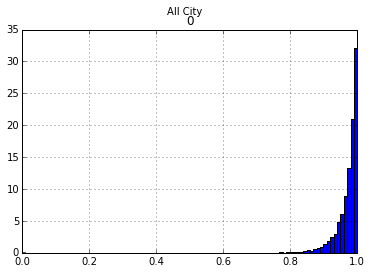

In [113]:
all_0_related_pd = doExperiment(df_hotel_profiles,0,'All City', [0,35])

2298
2638821
3
(2298,)
(2298,)


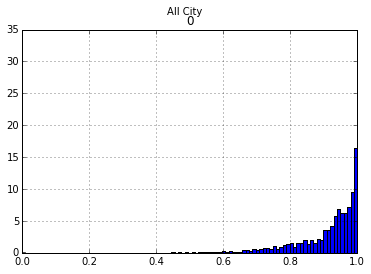

In [114]:
all_1_related_pd = doExperiment(df_hotel_profiles,1, 'All City', [0,35])

In [118]:
df_hotel_profiles[[ 'hotel_id','related_hotels']][df_hotel_profiles['hotel_id']=='Phoenix_Park_Hotel'].values

array([['Phoenix_Park_Hotel',
        array(['Dergvale_Hotel', 'Ballsbridge_Hotel', 'Lynam_s_Hotel',
       'Paramount_Hotel_Temple_Bar', 'Gate_Hotel', 'The_Belvedere_Hotel',
       'The_Townhouse', 'Caulfield_s_Hotel', 'Arlington_Hotel_Temple_Bar',
       'Ripley_Court_Hotel'], dtype=object)]], dtype=object)

In [125]:
all_1_related_pd[0][[ 'hotel_id','rank_trip_related_hotels','rank_trip_related_hotels_sims']][all_1_related_pd[0]['hotel_id']=='Phoenix_Park_Hotel'].values

array([['Phoenix_Park_Hotel',
        "['Gate_Hotel', 'Ballsbridge_Hotel', 'Paramount_Hotel_Temple_Bar', 'The_Townhouse', 'Ripley_Court_Hotel', 'Lynam_s_Hotel', 'The_Belvedere_Hotel', 'Arlington_Hotel_Temple_Bar', 'Caulfield_s_Hotel', 'Dergvale_Hotel']",
        '[1.0, 0.9938837346736189, 0.97560975609756106, 0.97560975609756106, 0.97560975609756106, 0.952925780013262, 0.952925780013262, 0.952925780013262, 0.9091418154532771, 0.83957015715215122]']], dtype=object)

In [127]:
city_final_pd[[ 'hotel_id','rank_trip_related_hotels','rank_trip_related_hotels_sims']][city_final_pd['hotel_id']=='Phoenix_Park_Hotel'].values

array([['Phoenix_Park_Hotel',
        "['Gate_Hotel', 'Lynam_s_Hotel', 'Ballsbridge_Hotel', 'Paramount_Hotel_Temple_Bar', 'The_Townhouse', 'Ripley_Court_Hotel', 'The_Belvedere_Hotel', 'Arlington_Hotel_Temple_Bar', 'Caulfield_s_Hotel', 'Dergvale_Hotel']",
        '[1.0, 0.99519741087467595, 0.99519741087467573, 0.95667388042885848, 0.95667388042885848, 0.95667388042885848, 0.90588235294117647, 0.90588235294117647, 0.78985231415738555, 0.75044029672813128]']], dtype=object)

In [152]:
city_final_Z[[ 'hotel_id','rank_trip_related_hotels','rank_trip_related_hotels_sims']][city_final_Z['hotel_id']=='Phoenix_Park_Hotel'].values


array([['Phoenix_Park_Hotel',
        "['Dergvale_Hotel', 'Paramount_Hotel_Temple_Bar', 'Ballsbridge_Hotel', 'The_Townhouse', 'Lynam_s_Hotel', 'Arlington_Hotel_Temple_Bar', 'Caulfield_s_Hotel', 'Gate_Hotel', 'The_Belvedere_Hotel', 'Ripley_Court_Hotel']",
        '[0.98862594069442999, 0.9852939148080968, 0.97200583843014776, 0.96760512983135849, 0.96464623613319822, 0.96464239401160734, 0.95875507382089908, 0.95864680511361111, 0.9566437360039296, 0.95305389069770496]']], dtype=object)

In [156]:
city_final_Z[[ 'hotel_id','rank_trip_related_hotels','rank_trip_related_hotels_sims']][city_final_Z['hotel_id']=='Phoenix_Park_Hotel'].values


array([['Phoenix_Park_Hotel',
        "['Dergvale_Hotel', 'Ballsbridge_Hotel', 'Lynam_s_Hotel', 'Paramount_Hotel_Temple_Bar', 'Gate_Hotel', 'The_Belvedere_Hotel', 'The_Townhouse', 'Caulfield_s_Hotel', 'Arlington_Hotel_Temple_Bar', 'Ripley_Court_Hotel']",
        '[0.95844710374430653, 0.95679657296101617, 0.95451719290348147, 0.9498348276142109, 0.94754569204992667, 0.94662239059708919, 0.94571524719079147, 0.94378740480154799, 0.93928772948982464, 0.93891587295614332]']], dtype=object)

In [120]:
all_1_related_pd[0].head()

,hotel_id,related_hotels,related_hotels_sims,rank_trip_related_hotels,rank_trip_related_hotels_sims
0,10_Lee_s_Place,"[London_City_Suites_By_Montcalm, Hilton_Garden...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","['Antoinette_Hotel_Wimbledon', 'The_Omega_Hote...","[0.98600391185174896, 0.98299483236962693, 0.9..."
1,130_Queen_s_Gate_Apartments,"[The_Landmark_London, St_Martins_Lane_London_H...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","['Citadines_Prestige_Holborn_Covent_Garden', '...","[0.99497512593277393, 0.99497512593277393, 0.9..."
2,196_Bishopsgate,"[Langorf_Hotel_Apartments, Grand_Mercure_Roxy_...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","['Abbey_Court_Hyde_Park', 'London_City_Hotel',...","[0.99842485135211367, 0.99599156296830227, 0.9..."
3,1_Lexham_Gardens,"[Central_Park_Hotel, St_Joseph_Hotel, Kensingt...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","['St_Joseph_Hotel', 'Kings_Hotel', 'Newham_Hot...","[1.0, 0.98994949366116647, 0.96561575852066972..."
4,21_Whitfield,"[The_Fielding_Hotel, Butterfly_on_Victoria, Ho...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","['Cheung_Chau_B_B', 'Lodgewood_by_L_hotel_Mong...","[0.99954240450065079, 0.99878610324567485, 0.9..."


In [121]:
with pd.HDFStore('/home/ruihaidong/workspace/explanations_framework/notebooks/explanations2.h5', format='f', mode='a', complevel=6, complib='blosc') as store:
    store['hotel_baseline_all_1'] = all_1_related_pd[0]

/home/ruihaidong/venv27/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3066: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['hotel_id', 'related_hotels', 'related_hotels_sims', 'rank_trip_related_hotels', 'rank_trip_related_hotels_sims']]

  exec(code_obj, self.user_global_ns, self.user_ns)


#### Consider location (Finding related hotels in the same city)

In [122]:
groupedByCity = df_hotel_profiles.groupby(['city'])

In [123]:
cities = pd.unique(df_hotel_profiles[['city']].values.ravel())
print cities

['London' 'Hong kong' 'New York' 'Singapore' 'Chicago' 'Dublin']


10_Lee_s_Place
1001
500392
3
(1001,)
(1001,)
21_Whitfield
315
49454
3
(315,)
(315,)
254_East_Vacation
401
79373
3
(401,)
(401,)
ABC_Hostel
275
37673
3
(275,)
(275,)
ACME_Hotel_Company_Chicago
143
10104
3
(143,)
(143,)
Aberdeen_Lodge
163
13201
3
(163,)
(163,)


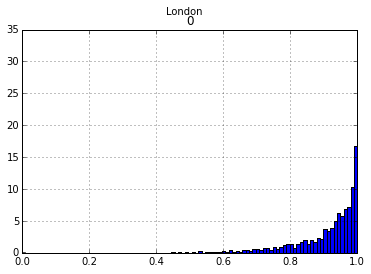

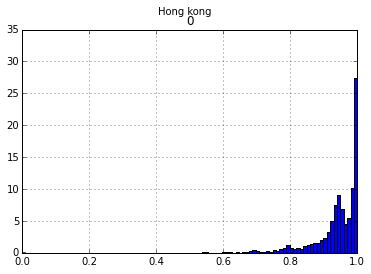

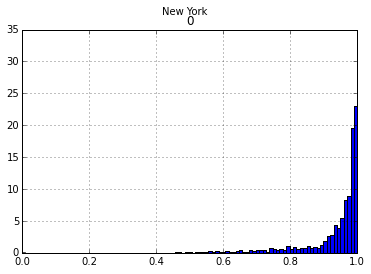

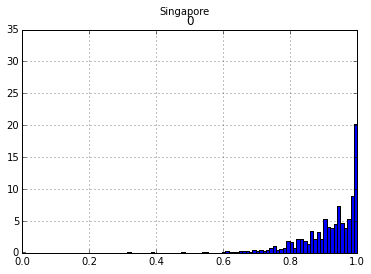

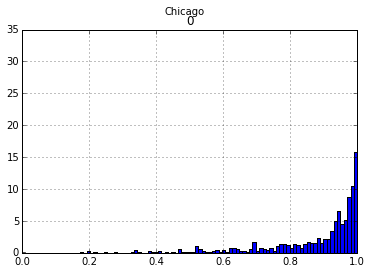

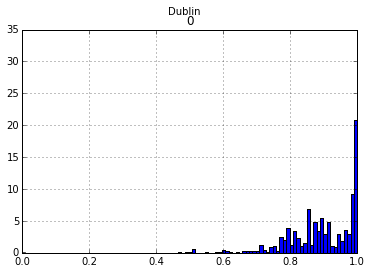

In [124]:
city_pds = []
city_pds_trip_sims = []
city_pds_new_sims = []

for ci in range(len(cities)):
    cdf = groupedByCity.get_group(cities[ci])
    print cdf.iloc[0].hotel_id
    cdf.reindex()
    city_related_pd = doExperiment(cdf,1,cities[ci],[0,35])
    city_pds.append(city_related_pd[0])
    city_pds_trip_sims.extend(city_related_pd[1])
    city_pds_new_sims.extend(city_related_pd[2])
   
city_final_pd = pd.concat(city_pds)

with pd.HDFStore('/home/ruihaidong/workspace/explanations_framework/notebooks/explanations2.h5', format='f', mode='a', complevel=6, complib='blosc') as store:
    store['hotel_baseline_city_1'] = city_final_pd

### Obvering hotel mention z-score

In [129]:
df_basic3=df_basic4

In [130]:
print len(df_basic3)

2298


In [131]:
mentions = np.array([z for z in df_basic3.target_hotel_mentions])

In [132]:
zmatrix = buildHotelZscoreMatrix(df_basic3)
zmatrix2 = rebuildZscoreMatrix(zmatrix)

In [133]:
zmatrix[0,:]

array([-0.33087622, -0.56697837, -0.18479688, -1.14988505, -0.25300699,
       -0.2845374 , -0.3932841 , -0.45050816,  1.47151118,  1.79748604,
       -0.836969  ,  4.2254496 , -1.24152668, -0.31704676, -0.72056438,
       -0.08020387, -0.3406783 , -0.08230665, -0.59905697])

In [134]:
v0 = zmatrix[:,0]
v0s = v0.argsort()
print v0s[0]
print v0[v0s[0]]
print zmatrix2[928,0]

0
-0.330876223527
-0.273709490609


In [1554]:
(35./200) * 6.5

1.1375

We have two version z_score, first one (z1) is original z , and second one(z2) is amplication of 2.5% to 97.5%
Each line has four figures, 
- 1 mention score (cumulative)
- 2 Z1 (cumulative)
- 3 z2 (cumulative)
- 4 z2

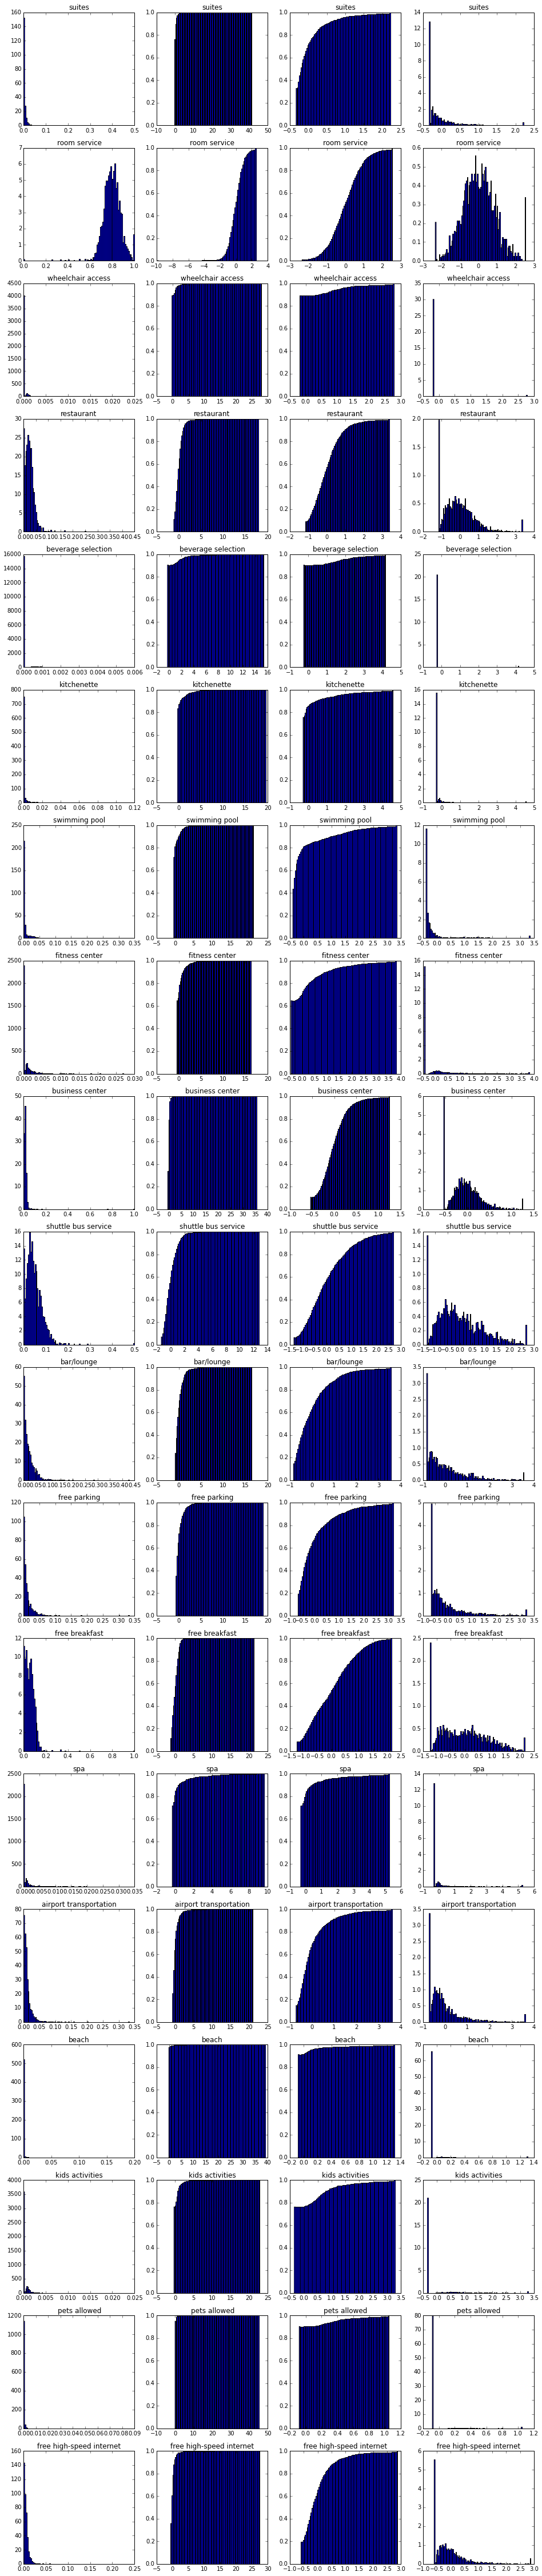

In [135]:
#gs = gridspec.GridSpec(19, 2)

fig = plt.figure(figsize=(16,80)) 
gs = gridspec.GridSpec(19, 4)

for col_index in range(len(zmatrix[0])):
    #print col_index

    ax1 = plt.subplot(gs[col_index,0])
    plt.hist(mentions[:,col_index], bins=100,normed=True, label='m')
    ax1.set_title(df_amenities.iloc[col_index]['amenity'])

    ax2 = plt.subplot(gs[col_index,1])
    plt.hist(zmatrix[:,col_index], bins=100,normed=True,cumulative=True, label='z')
    ax2.set_title(df_amenities.iloc[col_index]['amenity'])
    
    ax3 = plt.subplot(gs[col_index,2])
    plt.hist(zmatrix2[:,col_index], bins=100,normed=True, cumulative=True, label='z2 cumulative')
    ax3.set_title(df_amenities.iloc[col_index]['amenity'])
    
    ax4 = plt.subplot(gs[col_index,3])
    plt.hist(zmatrix2[:,col_index], bins=100,normed=True, label = 'z2')
    ax4.set_title(df_amenities.iloc[col_index]['amenity'])

    #pd.DataFrame(zmatrix[:,col_index]).hist(bins=200, cumulative=False, normed=True)
    #pl.suptitle(df_amenities.iloc[col_index]['amenity'])
    
    #pd.DataFrame(zmatrix2[:,col_index]).hist(bins=200, cumulative=False, normed=True)
    #pl.suptitle(df_amenities.iloc[col_index]['amenity'])
    

### mention z score and average raing, star and price range

#### Do not condiser location

(2298, 22)
2298
2639253


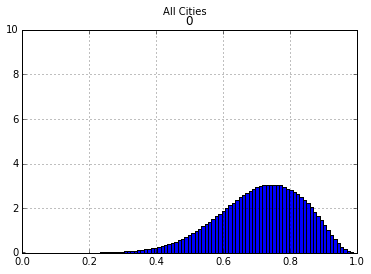

In [138]:
all_1_related_AZ_pd = doExperimentWithZmention(df_basic3, 1, 'All Cities', [0,10], True)

In [139]:
all_1_related_AZ_pd[0][:3]
#for v in all_1_related_AZ_pd.head(3).related_hotels_sims.values:
#    print sorted(v)

,hotel_id,related_hotels,related_hotels_sims,rank_trip_related_hotels,rank_trip_related_hotels_sims
0,10_Lee_s_Place,"[The_House_Hotel, 3_West_Club, Golden_Wave_Hot...","[0.928940642239, 0.906168930323, 0.89924926572...","['The_House_Hotel', 'Antoinette_Hotel_Wimbledo...","[0.92894064223924055, 0.88414517022089512, 0.8..."
1,130_Queen_s_Gate_Apartments,"[Abba_Queen_s_Gate_Hotel, Draycott_Hotel, Cour...","[0.949124795214, 0.944466107879, 0.94436214043...","['Abba_Queen_s_Gate_Hotel', 'Collingham_Servic...","[0.94912479521390014, 0.92862365117108825, 0.9..."
2,196_Bishopsgate,"[Abbey_Court_Hyde_Park, The_Mansions_Apartment...","[0.949323858241, 0.948395928685, 0.94828731616...","['Abbey_Court_Hyde_Park', 'Sydney_House', 'Pri...","[0.94932385824137233, 0.94828731616209139, 0.9..."


In [140]:
with pd.HDFStore('/home/ruihaidong/workspace/explanations_framework/notebooks/explanations2.h5', format='f', mode='a', complevel=6, complib='blosc') as store:
    store['hotel_baseline_all_1_AZ'] = all_1_related_AZ_pd[0]

#### Consider location and using metion z score (Finding related hotels in the same city)

In [141]:
groupedByCity3 = df_basic3.groupby(['city'])

(1001, 22)
1001
500500
(315, 22)
315
49455
(401, 22)
401
80200
(275, 22)
275
37675
(143, 22)
143
10153
(163, 22)
163
13203


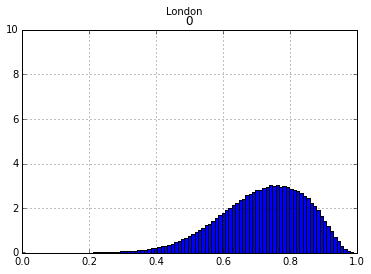

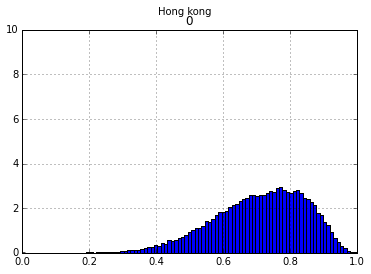

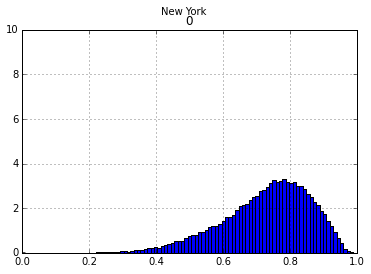

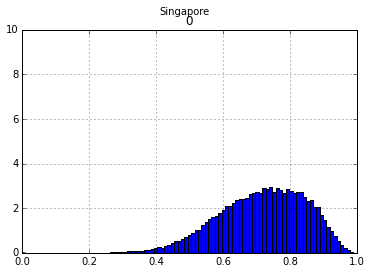

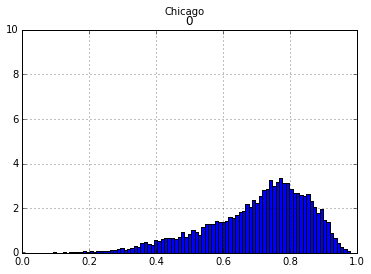

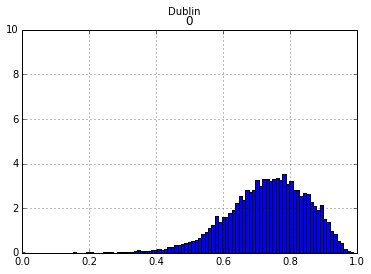

In [142]:
city_pds_AZ = []
city_pds_trip_sims_AZ = []
city_pds_new_sims_AZ = []
for ci in range(len(cities)):
    #print cities[ci]
    cdf = groupedByCity3.get_group(cities[ci])
    city_related_pd = doExperimentWithZmention(cdf, 1, cities[ci], [0,10],True)
    city_pds_AZ.append(city_related_pd[0])
    city_pds_trip_sims_AZ.extend(city_related_pd[1])
    city_pds_new_sims_AZ.extend(city_related_pd[2])
   
city_final_AZ = pd.concat(city_pds_AZ)
with pd.HDFStore('/home/ruihaidong/workspace/explanations_framework/notebooks/explanations2.h5', format='f', mode='a', complevel=6, complib='blosc') as store:
    store['hotel_baseline_city_1_AZ'] = city_final_AZ

In [143]:
with pd.HDFStore('/home/ruihaidong/workspace/explanations_framework/notebooks/explanations2.h5', format='f', mode='r') as store:
    print store
    df_hotel_baseline_city_1_AZ = store['hotel_baseline_city_1_AZ']

<class 'pandas.io.pytables.HDFStore'>
File path: /home/ruihaidong/workspace/explanations_framework/notebooks/explanations2.h5
/hotel_baseline_all_1                frame        (shape->[1,5])
/hotel_baseline_all_1_AZ             frame        (shape->[1,5])
/hotel_baseline_all_1_Z              frame        (shape->[1,5])
/hotel_baseline_city_1               frame        (shape->[1,5])
/hotel_baseline_city_1_AZ            frame        (shape->[1,5])
/hotel_baseline_city_1_Z             frame        (shape->[1,5])
/hotel_baseline_city_3               frame        (shape->[1,3])


In [146]:
df_hotel_baseline_city_1_AZ[df_hotel_baseline_city_1_AZ['hotel_id']=='Phoenix_Park_Hotel']

,hotel_id,related_hotels,related_hotels_sims,rank_trip_related_hotels,rank_trip_related_hotels_sims
117,Phoenix_Park_Hotel,"[Gate_Hotel, Ballsbridge_Hotel, Paramount_Hote...","[0.965633505425, 0.963597171638, 0.95167912542...","['Gate_Hotel', 'Ballsbridge_Hotel', 'Paramount...","[0.96563350542471382, 0.9635971716382673, 0.95..."


In [145]:
rs = df_hotel_baseline_city_1_AZ[df_hotel_baseline_city_1_AZ['hotel_id']=='Phoenix_Park_Hotel'].related_hotels
rslist = np.array(rs)
print rslist

rs = df_hotel_baseline_city_1_AZ[df_hotel_baseline_city_1_AZ['hotel_id']=='Phoenix_Park_Hotel'].rank_trip_related_hotels
rslist = np.array(rs)
print rslist

[ array(['Gate_Hotel', 'Ballsbridge_Hotel', 'Paramount_Hotel_Temple_Bar',
       'The_Townhouse', 'Ripley_Court_Hotel',
       'Lansdowne_Hotel_Ballsbridge', 'Le_Cirk_Hotel', 'Hazelbrook_House',
       'The_Belvedere_Hotel', 'Tara_Towers_Hotel'], dtype=object)]
[ "['Gate_Hotel', 'Ballsbridge_Hotel', 'Paramount_Hotel_Temple_Bar', 'The_Townhouse', 'Ripley_Court_Hotel', 'The_Belvedere_Hotel', 'Arlington_Hotel_Temple_Bar', 'Lynam_s_Hotel', 'Dergvale_Hotel', 'Caulfield_s_Hotel']"]


### Only consider z-mention

(2298, 19)
2298
2636113


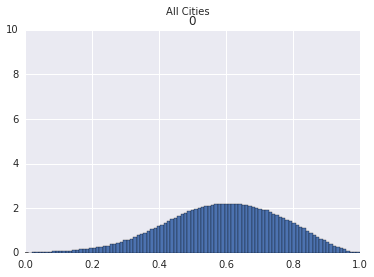

In [1947]:
all_1_related_Z_pd = doExperimentWithZmention(df_basic3, 1, 'All Cities', [0,10], False)

In [1948]:
with pd.HDFStore('/home/ruihaidong/workspace/explanations_framework/notebooks/explanations2.h5', format='f', mode='a', complevel=6, complib='blosc') as store:
    store['hotel_baseline_all_1_Z'] = all_1_related_Z_pd[0]

(1001, 19)
1001
500218
(315, 19)
315
49321
(401, 19)
401
80139
(275, 19)
275
37608
(143, 19)
143
10129
(163, 19)
163
13188


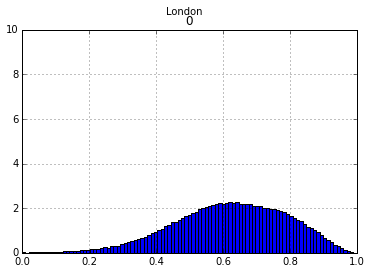

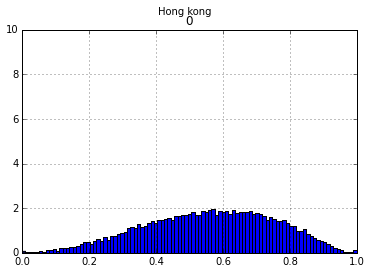

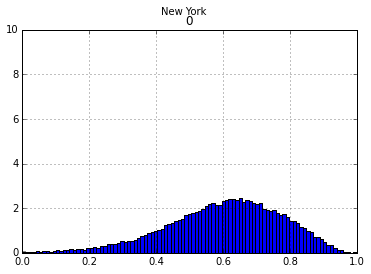

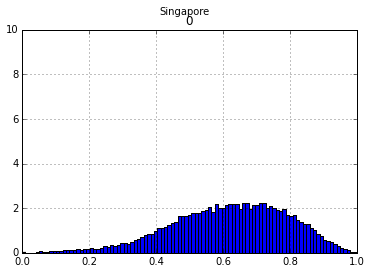

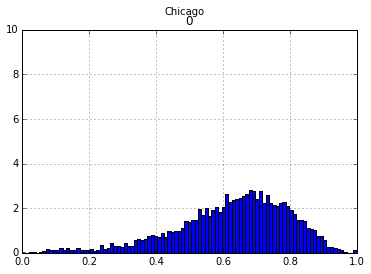

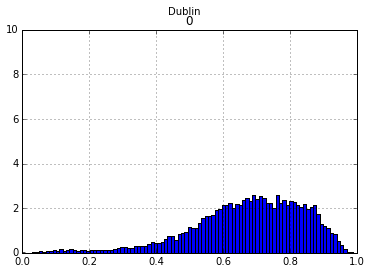

In [155]:
city_pds_Z = []
city_pds_trip_sims_Z = []
city_pds_new_sims_Z = []
for ci in range(len(cities)):
    #print cities[ci]
    cdf = groupedByCity3.get_group(cities[ci])   
    city_related_pd = doExperimentWithZmention(cdf, 1, cities[ci], [0,10], False)
    city_pds_Z.append(city_related_pd[0])
    
    city_pds_trip_sims_Z.extend(city_related_pd[1])
    city_pds_new_sims_Z.extend(city_related_pd[2])
   
city_final_Z = pd.concat(city_pds_Z)
with pd.HDFStore('/home/ruihaidong/workspace/explanations_framework/notebooks/explanations2.h5', format='f', mode='a', complevel=6, complib='blosc') as store:
    store['hotel_baseline_city_1_Z'] = city_final_Z

In [148]:
city_final_Z[0:10]

,hotel_id,related_hotels,related_hotels_sims,rank_trip_related_hotels,rank_trip_related_hotels_sims
0,10_Lee_s_Place,"[The_House_Hotel, Travelodge_London_Whetstone,...","[0.926395145835, 0.842649988598, 0.82308289240...","['The_House_Hotel', 'Travelodge_London_Whetsto...","[0.92639514583451454, 0.84264998859761275, 0.8..."
1,130_Queen_s_Gate_Apartments,"[Think_Earl_s_Court, Citadines_Prestige_Holbor...","[0.899153587012, 0.88333329246, 0.872035138987...","['Think_Earl_s_Court', 'Citadines_Prestige_Hol...","[0.89915358701178105, 0.88333329246025671, 0.8..."
2,196_Bishopsgate,"[Sydney_House, Abbey_Court_Hyde_Park, Prince_s...","[0.923207182244, 0.909373534625, 0.90515350387...","['Sydney_House', 'Abbey_Court_Hyde_Park', 'Pri...","[0.92320718224430143, 0.90937353462469961, 0.9..."
3,1_Lexham_Gardens,"[The_Z_Hotel_Soho, Kensington_Rooms, St_Joseph...","[0.976923297822, 0.976730261496, 0.97551117913...","['The_Z_Hotel_Soho', 'Kensington_Rooms', 'St_J...","[0.97692329782233311, 0.97673026149628928, 0.9..."
4,27_Paddington,"[Airways_Hotel_Victoria_London, Bayswater_Inn,...","[0.992330838409, 0.982746314115, 0.98224310338...","['Airways_Hotel_Victoria_London', 'Bayswater_I...","[0.99233083840889025, 0.9827463141147581, 0.98..."
5,37_Collingham_Place_London,"[Basil_Street_Apartments, Royal_Court_Apartmen...","[0.940993678978, 0.938469777027, 0.93461720607...","['Basil_Street_Apartments', 'Royal_Court_Apart...","[0.940993678978294, 0.93846977702685674, 0.934..."
6,39_Suites,"[Royal_Court_Apartments, Space_Apart_Hotel, Cl...","[0.962052430749, 0.962030259928, 0.95330704925...","['Royal_Court_Apartments', 'Space_Apart_Hotel'...","[0.96205243074867386, 0.96203025992782432, 0.9..."
7,44_Curzon_Street_Apartments,"[Fraser_Place_Canary_Wharf, Think_Earl_s_Court...","[0.888903703458, 0.88205675549, 0.880027784691...","['Fraser_Place_Canary_Wharf', 'Think_Earl_s_Co...","[0.88890370345824543, 0.88205675548992502, 0.8..."
8,45_Park_Lane,"[The_Park_Tower_Knightsbridge, The_Beaufort_Ho...","[0.932667739122, 0.923504463924, 0.90690506970...","['The_Park_Tower_Knightsbridge', 'The_Beaufort...","[0.93266773912233203, 0.92350446392433205, 0.9..."
9,47_Prince_s_Gardens_Guest_Rooms_Apartments,"[The_Courthouse_Doubletree_by_Hilton, Henry_VI...","[0.868624885465, 0.857047108268, 0.85279204967...","['The_Courthouse_Doubletree_by_Hilton', 'Henry...","[0.8686248854651003, 0.85704710826845276, 0.85..."


In [1951]:
city_final_Z.iloc[100].hotel_id

'Bentinck_House_Hotel'

In [1952]:
sims_AZ = np.array([z for z in all_1_related_AZ_pd[0].related_hotels_sims]).ravel()
sims_city_AZ = np.array([z for z in city_final_AZ.related_hotels_sims]).ravel()

sims_A = np.array([z for z in all_1_related_pd[0].related_hotels_sims]).ravel()
sims_city_A = np.array([z for z in city_final_pd.related_hotels_sims]).ravel()

sims_Z = np.array([z for z in all_1_related_Z_pd[0].related_hotels_sims]).ravel()
sims_city_Z = np.array([z for z in city_final_Z.related_hotels_sims]).ravel()



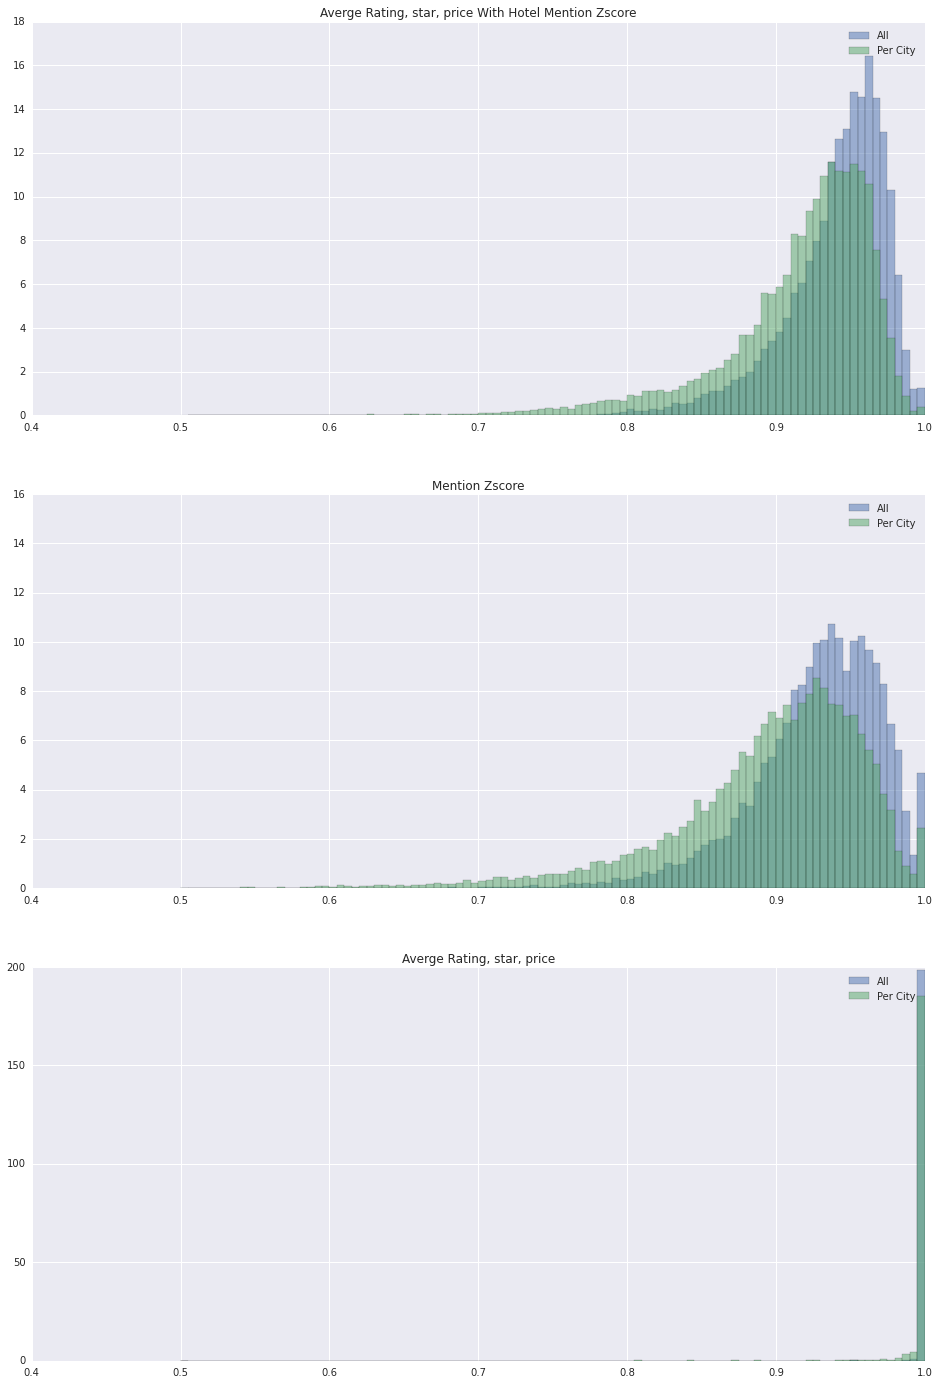

In [1953]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import plotly.plotly as py  # tools to communicate with Plotly's server

fig = plt.figure(figsize=(16, 24)) 
gs2 = gridspec.GridSpec(3, 1)

ax1 = plt.subplot(gs2[0,0])
plt.hist(sims_AZ, bins=100, alpha=0.5,range=[0.5,1],normed=True,label='All')
plt.hist(sims_city_AZ, bins=100, alpha=0.5,range=[0.5,1],normed=True,label='Per City')
plt.legend(loc='upper right')
ax1.set_title('Averge Rating, star, price With Hotel Mention Zscore')

ax2 = plt.subplot(gs2[1,0])
plt.hist(sims_Z, bins=100, alpha=0.5,range=[0.5,1],normed=True,label='All')
plt.hist(sims_city_Z, bins=100, alpha=0.5,range=[0.5,1],normed=True,label='Per City')
plt.legend(loc='upper right')
plt.ylim([0,16])
ax2.set_title('Mention Zscore')

ax3 = plt.subplot(gs2[2,0])
plt.hist(sims_A, bins=100, alpha=0.5,range=[0.5,1],normed=True,label='All')
plt.hist(sims_city_A, bins=100, alpha=0.5,range=[0.5,1],normed=True,label='Per City')
ax3.set_title('Averge Rating, star, price')

plt.legend(loc='upper right')

### Average rating correlation (Similarity correlation) between Dong baseline and TripAdvisor baseline

In [1876]:
from scipy.stats.stats import pearsonr
import seaborn as sns

In [1877]:
def calculateAverageCorrelation(df_hotel,df_trip,df_related,key,title):
    relatedAverage = generateAverageOfRelated(df_hotel,df_related,key)
    trip_average = generateAverageOfRelated(df_hotel,df_trip,key)
    dong = []
    trip = []
    for hid in relatedAverage:
        ca = relatedAverage.get(hid,None)
        ta = trip_average.get(hid,None)
        if ca==None or ta==None:
            continue
        dong.append(ca)
        trip.append(ta)
    dong_trip_cor_input = pd.DataFrame({'New':dong,'TripBase':trip})
    sns.jointplot(x="New", y="TripBase", data=dong_trip_cor_input);

- Average Rating, Price, Star, and Hotel mention-zscore

#### Average Rating (Do not consider city)

10
8


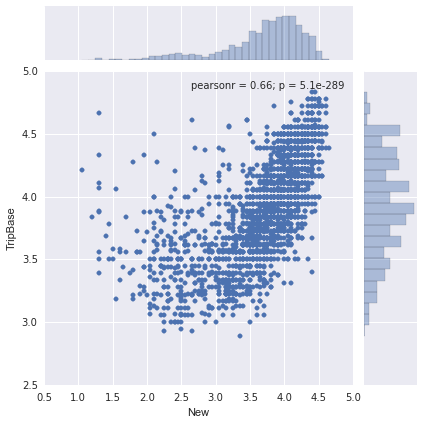

In [1878]:
calculateAverageCorrelation(df_hotel_profiles,df_hotel_profiles,all_1_related_AZ_pd[0],'average_rating','All AZ')

#### Average Rating (City Versity)

10
8


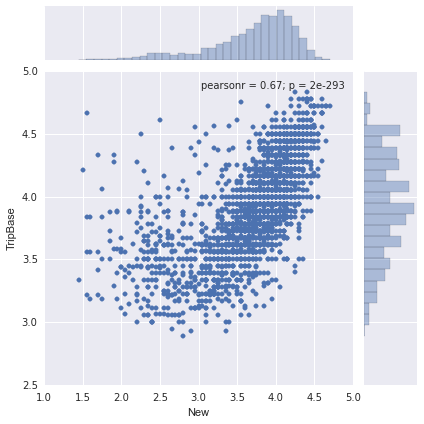

In [1879]:
calculateAverageCorrelation(df_hotel_profiles,df_hotel_profiles,city_final_AZ,'average_rating','City AZ')

#### Average Similarity (Do not consider city)

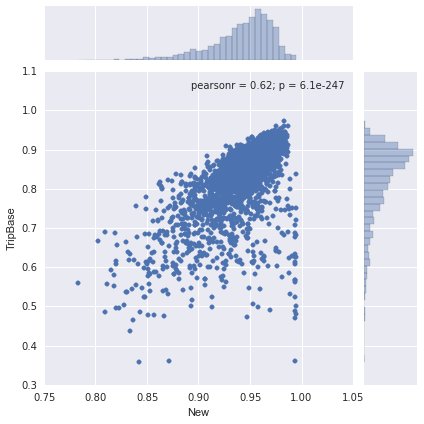

In [1880]:
dong_trip_sim_input = pd.DataFrame({'New':all_1_related_AZ_pd[2],'TripBase':all_1_related_AZ_pd[1]})
sns.jointplot(x="New", y="TripBase", data=dong_trip_sim_input);

#### Average Similarity (City verstion)

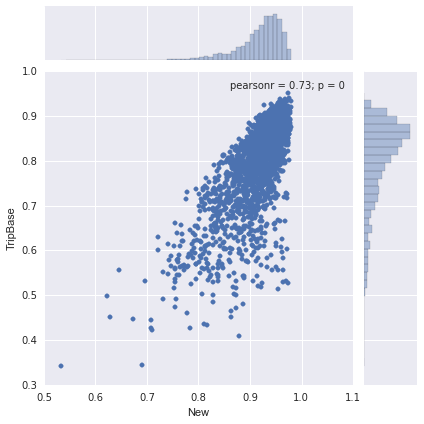

In [1881]:
dong_trip_sim_input = pd.DataFrame({'New':city_pds_new_sims_AZ,'TripBase':city_pds_trip_sims_AZ})
sns.jointplot(x="New", y="TripBase", data=dong_trip_sim_input);

- Average Rating, Price, Star

#### Average Rating (Do not consider city)

10
8


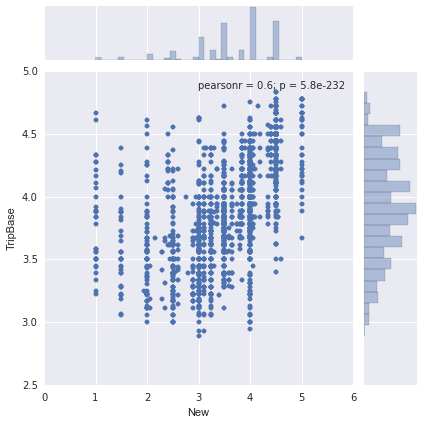

In [1882]:
calculateAverageCorrelation(df_hotel_profiles,df_hotel_profiles,all_1_related_pd[0],'average_rating','All A')

#### Average rating (city version)

10
8


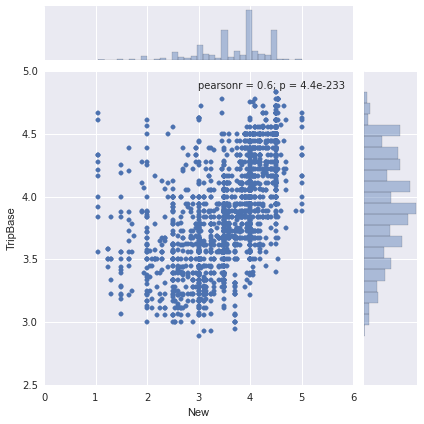

In [1883]:
calculateAverageCorrelation(df_hotel_profiles,df_hotel_profiles,city_final_pd,'average_rating','City A')

#### Average Similarity (Do not consider city)

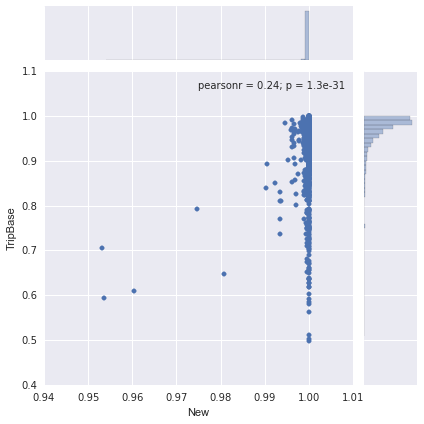

In [1884]:
dong_trip_sim_input = pd.DataFrame({'New':all_1_related_pd[2],'TripBase':all_1_related_pd[1]})
sns.jointplot(x="New", y="TripBase", data=dong_trip_sim_input);

#### Average Similarity (City version)

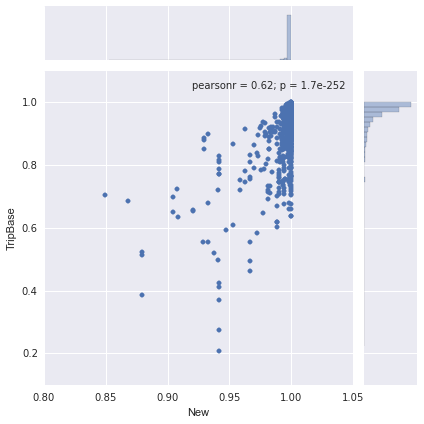

In [1885]:
dong_trip_sim_input = pd.DataFrame({'New':city_pds_new_sims,'TripBase':city_pds_trip_sims})
sns.jointplot(x="New", y="TripBase", data=dong_trip_sim_input);

- Hotel mention-zscore

#### Average Rating (Do not consider city)

10
8


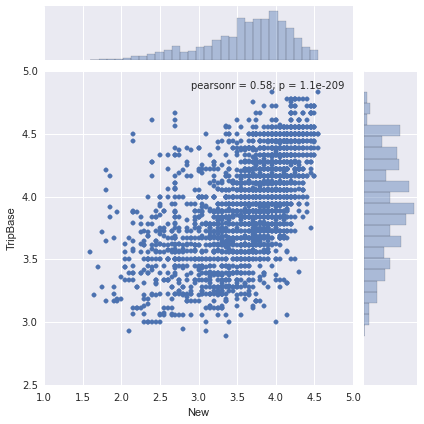

In [1886]:
calculateAverageCorrelation(df_hotel_profiles,df_hotel_profiles,all_1_related_Z_pd[0],'average_rating','All Z')

#### Average Rating (City Version)

10
8


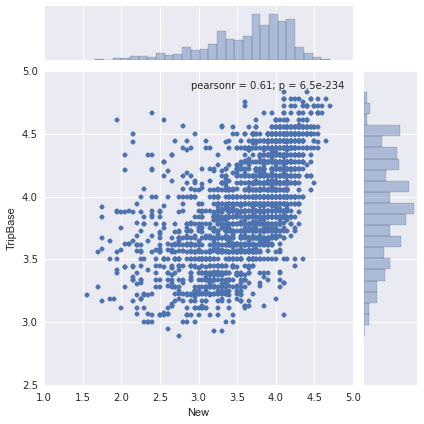

In [1887]:
calculateAverageCorrelation(df_hotel_profiles,df_hotel_profiles,city_final_Z,'average_rating','City Z')

#### Average Similarity (Do not consider city)

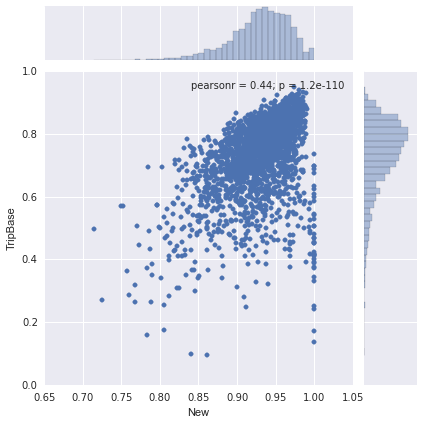

In [1888]:
dong_trip_sim_input = pd.DataFrame({'New':all_1_related_Z_pd[2],'TripBase':all_1_related_Z_pd[1]})
sns.jointplot(x="New", y="TripBase", data=dong_trip_sim_input);

#### Average Similarity (City version)

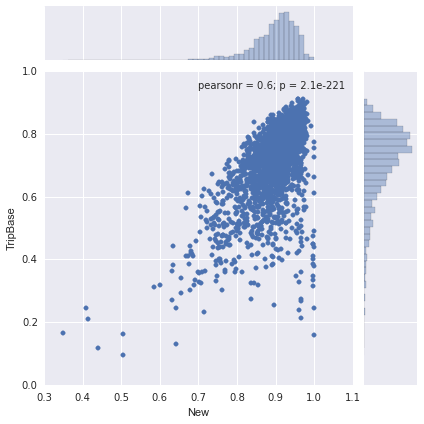

In [1889]:
dong_trip_sim_input = pd.DataFrame({'New':city_pds_new_sims_Z,'TripBase':city_pds_trip_sims_Z})
sns.jointplot(x="New", y="TripBase", data=dong_trip_sim_input);

10
8


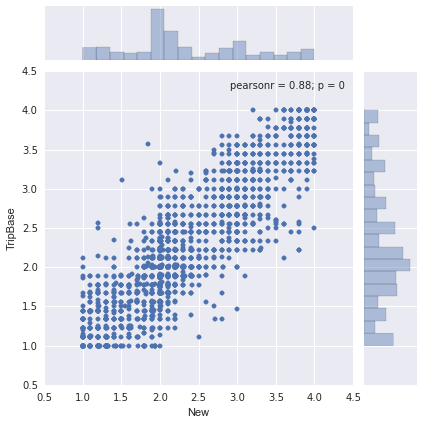

In [1596]:
calculateAverageCorrelation(df_hotel_profiles,df_hotel_profiles,all_1_related_AZ_pd,'price_range_value','All AZ')

10
8


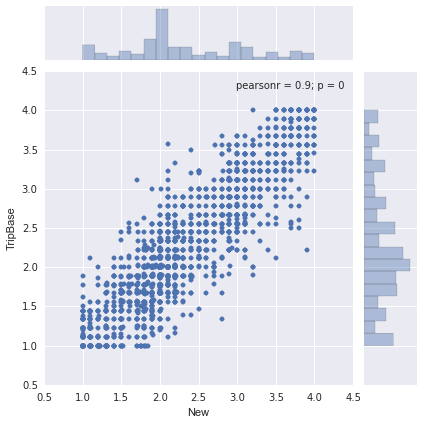

In [1597]:
calculateAverageCorrelation(df_hotel_profiles,df_hotel_profiles,city_final_AZ,'price_range_value','City AZ')

In [964]:
flights = sns.load_dataset("flights")

In [966]:
flights = flights.pivot("month", "year", "passengers")

In [968]:
flights[:3]

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
January,112,115,145,171,196,204,242,284,315,340,360,417
February,118,126,150,180,196,188,233,277,301,318,342,391
March,132,141,178,193,236,235,267,317,356,362,406,419


/home/ruihaidong/venv27/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


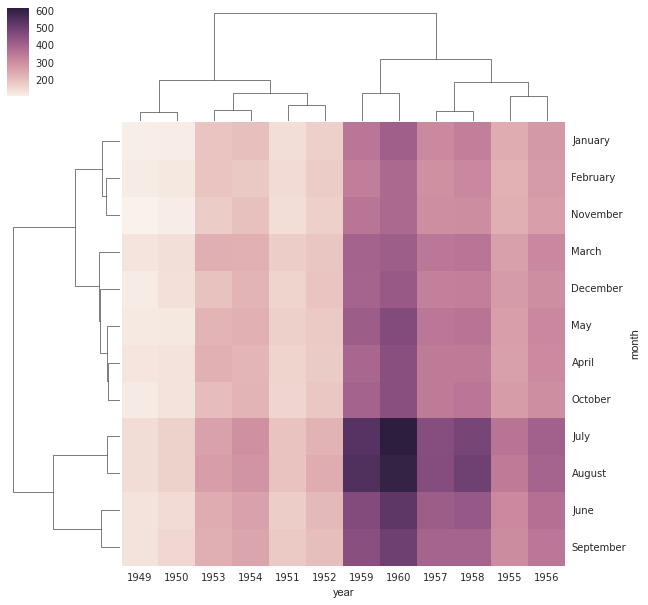

In [967]:
g = sns.clustermap(flights)

In [965]:
flights[:3]

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132


### Displaying Result

In [1443]:
with pd.HDFStore('/home/ruihaidong/workspace/explanations_framework/notebooks/explanations2.h5', format='f', mode='r') as store:
    print store
    df_hotel_baseline_all_1 = store['hotel_baseline_all_1']
    df_hotel_baseline_city_1 = store['hotel_baseline_city_1']
    

<class 'pandas.io.pytables.HDFStore'>
File path: /home/ruihaidong/workspace/explanations_framework/notebooks/explanations2.h5
/hotel_baseline_all_1                frame        (shape->[1,3])
/hotel_baseline_all_1_AZ             frame        (shape->[1,3])
/hotel_baseline_all_1_Z              frame        (shape->[1,3])
/hotel_baseline_city_1               frame        (shape->[1,3])
/hotel_baseline_city_1_AZ            frame        (shape->[1,3])
/hotel_baseline_city_1_Z             frame        (shape->[1,3])
/hotel_baseline_city_3               frame        (shape->[1,3])


In [1444]:
df_hotel_baseline_all_1.head()

,hotel_id,related_hotels,related_hotels_sims
0,10_Aarden_Hotel,"[Hotel_Belleclaire, Two_MacDonnell_Road, Hand_...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,10_Lee_s_Place,[Residence_Inn_New_York_Manhattan_Midtown_East...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,130_Queen_s_Gate_Apartments,"[St_James_s_Hotel_and_Club, Greenwich_Hotel, F...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,196_Bishopsgate,"[Holiday_Inn_London_Brentford_Lock, Clarion_Ho...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,1_Lexham_Gardens,"[Kensington_International_Hotel, Travelodge_Lo...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [622]:
len(df_hotel_baseline_all_1)

2370

In [623]:
df_hotel_baseline_city_1.head()

,hotel_id,related_hotels,related_hotels_sims
0,10_Aarden_Hotel,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,10_Lee_s_Place,"[Domaine_de_Bussas, Holiday_Inn_Oxford_Circus,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,130_Queen_s_Gate_Apartments,"[nan, Bakers_Hotel, nan, DoubleTree_by_Hilton_...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,196_Bishopsgate,"[Hilton_London_Green_Park, nan, Blades_Hotel, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,1_Lexham_Gardens,"[Hazlitt_s, Cromwell_Crown_Hotel, Hotel_Earls_...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99951207..."


In [624]:
len(df_hotel_baseline_city_1)

2370

In [625]:
def checkRelated(df_related):
    aveSim = []
    included = []
    for xind in range(len(df_related)):
        if df_related.iloc[xind].hotel_id in df_related.iloc[xind].related_hotels:
            included.append(df_related.iloc[xind].hotel_id)
        
        sims = np.array(df_related.iloc[xind].related_hotels_sims)
        #print sims.shape
        aveSim.append(np.mean(sims))
    
    print len(included)
    pd.DataFrame(np.array(aveSim)).hist(bins=np.linspace(0,1,100), cumulative=False, normed=True)

0


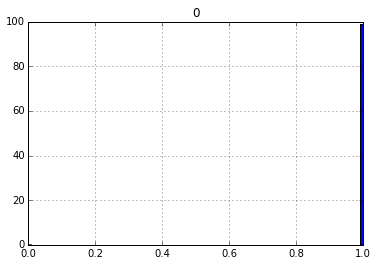

In [626]:

checkRelated(df_hotel_baseline_all_1)

5


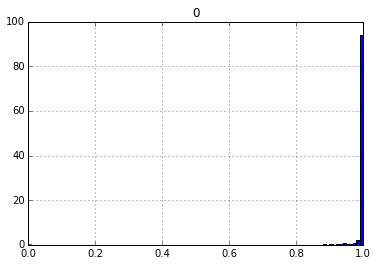

In [627]:

checkRelated(df_hotel_baseline_city_1)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbac7ad1fd0>]], dtype=object)

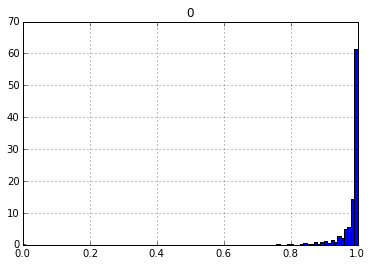

In [252]:
pd.DataFrame(np.ravel(hotel_sim_matrix)).hist(bins=np.linspace(0,1,100), cumulative=False, normed=True)
#pd.DataFrame(hotel_sim_matrix[i][:i] for i in xrange(hotel_sim_matrix.shape[0])).hist(bins=np.linspace(0,1,50), cumulative=True, normed=True)

In [216]:
df_amenities

,amenity
0,suites
1,room service
2,wheelchair access
3,restaurant
4,beverage selection
5,kitchenette
6,swimming pool
7,fitness center
8,business center
9,shuttle bus service


amenity    suites
Name: 0, dtype: object
amenity    room service
Name: 1, dtype: object
amenity    wheelchair access
Name: 2, dtype: object
amenity    restaurant
Name: 3, dtype: object
amenity    beverage selection
Name: 4, dtype: object
amenity    kitchenette
Name: 5, dtype: object
amenity    swimming pool
Name: 6, dtype: object
amenity    fitness center
Name: 7, dtype: object
amenity    business center
Name: 8, dtype: object
amenity    shuttle bus service
Name: 9, dtype: object
amenity    bar/lounge
Name: 10, dtype: object
amenity    free parking
Name: 11, dtype: object
amenity    free breakfast
Name: 12, dtype: object
amenity    spa
Name: 13, dtype: object
amenity    airport transportation
Name: 14, dtype: object
amenity    beach
Name: 15, dtype: object
amenity    kids activities
Name: 16, dtype: object
amenity    pets allowed
Name: 17, dtype: object
amenity    free high-speed internet
Name: 18, dtype: object


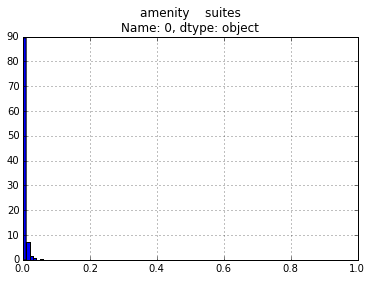

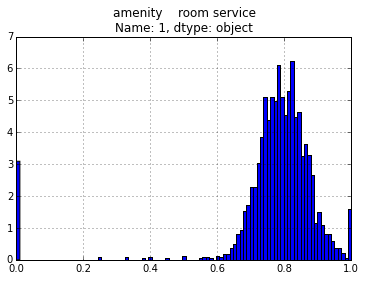

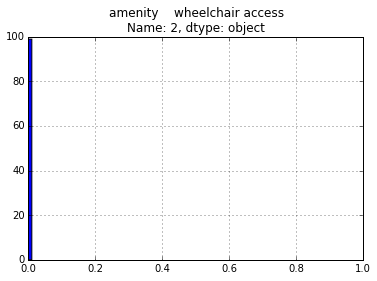

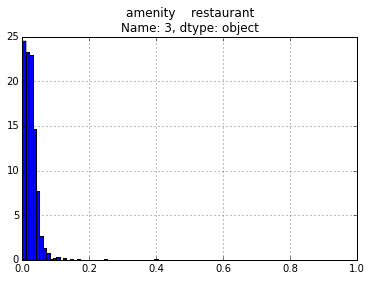

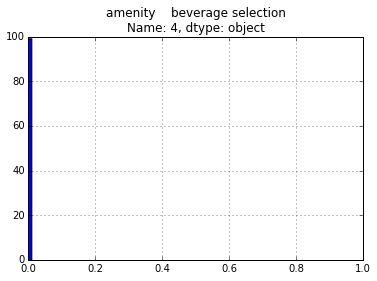

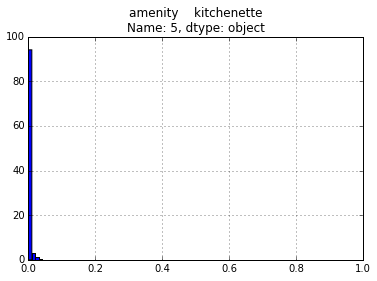

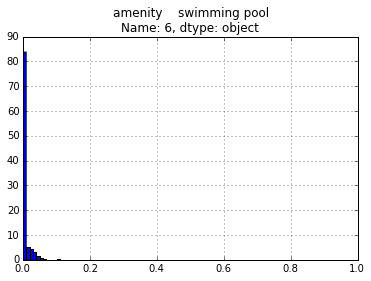

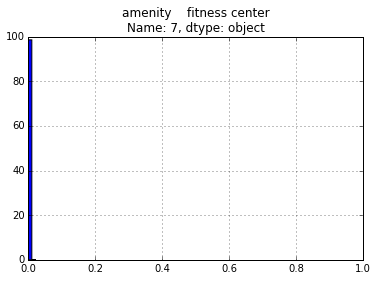

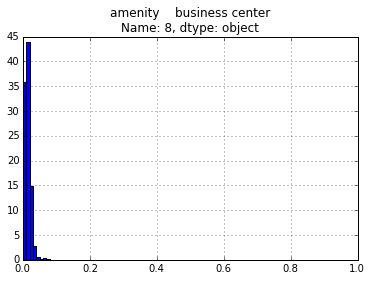

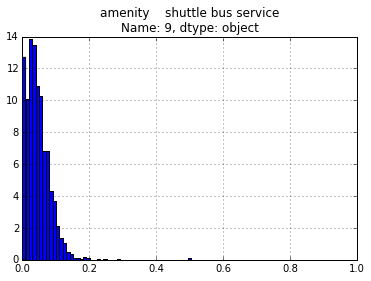

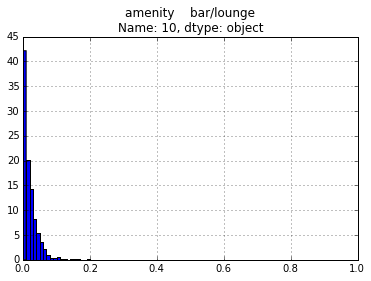

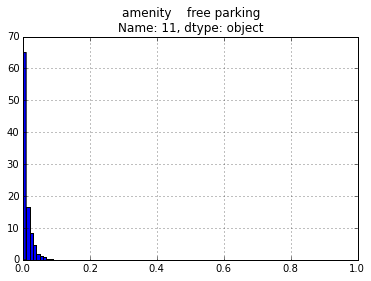

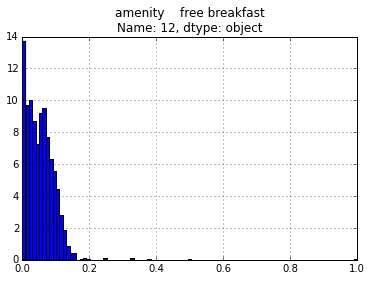

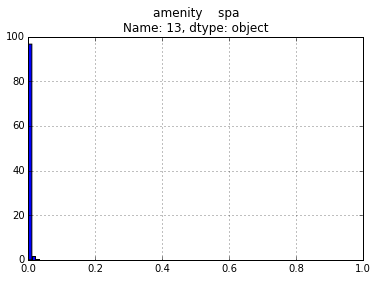

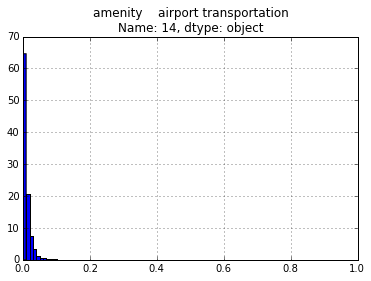

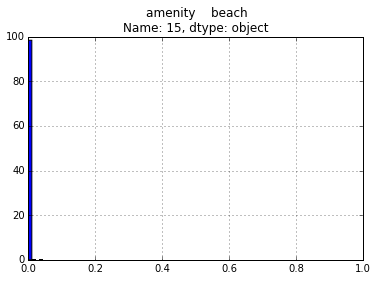

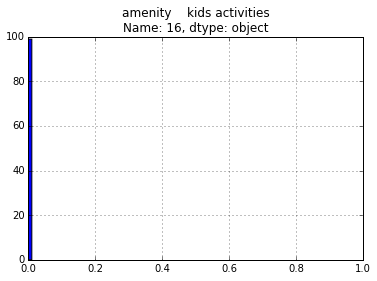

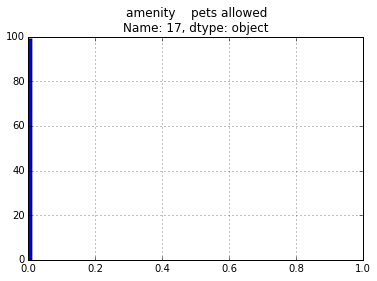

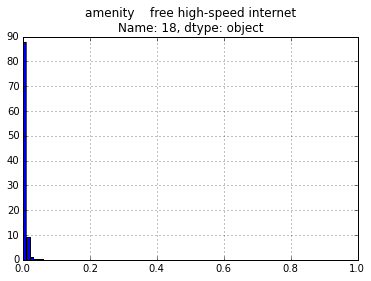

In [219]:
#f_idx = 1
for f_idx in xrange(0, 19):
    print df_amenities.ix[f_idx]
    pd.DataFrame( v[f_idx] for v in df_hotel_profiles.mentions.values ).hist(bins=np.linspace(0,1,100), cumulative=False, normed=True)
    plt.title("{}".format(df_amenities.ix[f_idx]))